In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit

In [2]:
def lif_dynamics(tau_m, E_l, noise_std, stimulus, v_t, dt, total_time):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps + 1)*dt

    sigma = np.sqrt(2.0 * noise_std * dt)
    noise_vals = np.random.normal(loc=0.0, scale=sigma, size=ntime_steps + 1)
    
    fixed_term = noise_vals + stimulus*dt

    v_m = np.zeros(ntime_steps + 1)
    v_m[0] = E_l
    t_spks = []
    # integration:
    t = 1
    while t < ntime_steps + 1:
        v_m[t] = v_m[t - 1] + ((-(v_m[t - 1] - E_l) * dt) + fixed_term[t])/tau_m
        if v_m[t] > v_t:
            v_m[t] = E_l
            t_spks.append(t*dt)
        t = t + 1

    return time_points, v_m, t_spks

In [3]:
tau_m = 0.023
e_l = -0.079
r_m = 10 # MOhm
v_t = -0.061

dt = 0.001
total_time = 5

noise_std = 2e-9
n_timepoints = int(total_time/dt) + 1
stimulus = np.ones(n_timepoints)*17.3*1e-3

#np.random.seed(1)
time, v_m, spks = lif_dynamics(tau_m, e_l, noise_std, stimulus, v_t, dt, total_time)

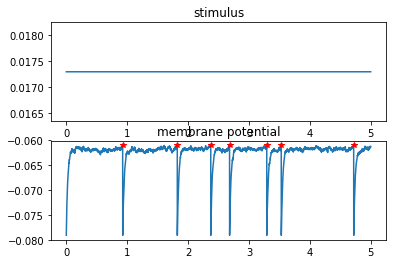

In [4]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(time, stimulus)
axes[0].set_title('stimulus')
axes[1].plot(time, v_m)
axes[1].set_title('membrane potential')
axes[1].plot(spks, np.ones(len(spks))*v_t, 'r*')

In [5]:
spks

[0.927, 1.824, 2.374, 2.6830000000000003, 3.294, 3.532, 4.722]

In [6]:
def g_syn(t, g_max, tau_syn):
    if t>= 0:
        return g_max * t / tau_syn * np.exp(-t/tau_syn)
    else:
        return 0

1.5


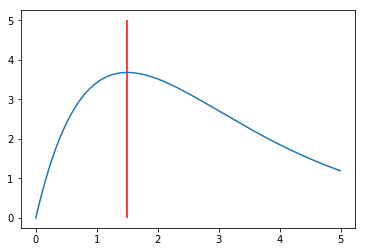

In [7]:
x = np.arange(500)*0.01
y = np.array([ g_syn(t, 10, 1.5) for t in x])
plt.plot(x, y)
ymax = np.argmax(y)
plt.vlines(x[ymax], 0, 5, 'r')
print(x[ymax])

## Stimulus generation (cf. Figure 1B and 1D of Bhattacharyya et. al 2017)

In [399]:
def generate_stimulus(stim_size=1, speed=1, length=10, dt=0.1, init_distance=50):
    timesteps = np.arange(int(length/dt))*dt
    distances = init_distance - timesteps*speed
    angles = np.arctan2(stim_size/2, distances)*2
    angles_degrees = angles/np.pi*180
    return timesteps, angles_degrees, distances

[ 131.57894737   65.78947368   44.64285714   33.78378378   26.88172043
   22.52252252]


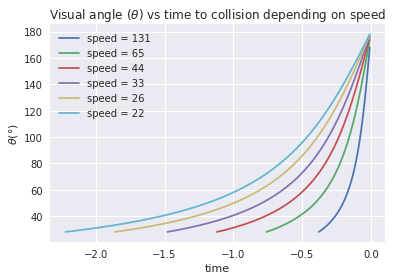

In [277]:
# these values are taken from Bhattacharyya et. al 2017:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 25
speeds = 1/(LV_vals/stim_size)
print(speeds)

#plt.figure(figsize=(8,8))
for speed in speeds:
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, dt=0.01)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    plt.plot(t_to_collision, stim_to_collision, label='speed = ' + str(int(speed)))
plt.xlabel('time')
plt.ylabel(r'$\theta (\degree)$')
plt.title(r'Visual angle ($\theta$) vs time to collision depending on speed')
plt.legend()
#print(dists)

In [10]:
# from preuss2006:
10/600

0.016666666666666666

## Linear function of visual angle

In [94]:
def f_theta_linear(theta, m, b):
    return theta*m + b

def transform_stim(stim_size, speed, length, dt, m=1.5, b=0):
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, length=length, dt=dt)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    transformed_stim_to_collision = f_theta_linear(stim_to_collision, m=m, b=b)
    transformed_stims = f_theta_linear(stims, m=m, b=b)
    return t, stims, transformed_stims, dists, t_to_collision, transformed_stim_to_collision

[ 131.57894737   65.78947368   44.64285714   33.78378378   26.88172043
   22.52252252]


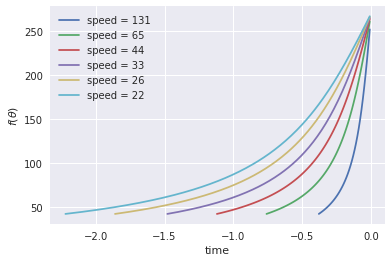

In [95]:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 25
length = 10
dt = 0.01
m = 1.5
b = 0
speeds = 1/(LV_vals/stim_size)
print(speeds)

#plt.figure(figsize=(8,8))
for speed in speeds:
    t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, length, dt, m, b)
    plt.plot(t_to_collision, transformed_stim_to_collision, label='speed = ' + str(int(speed)))
plt.xlabel('time')
plt.ylabel(r'$f(\theta)$')
plt.legend()
#print(dists)

## Leaky Integrate-and-Fire model of the Mauthner cell (adopted from Koyama et. al 2016)

In [96]:
def lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = e_l
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [97]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061

dt = 0.0001
total_time = 1

noise_std = 10*1e-15
n_timepoints = int(total_time/dt)

stimulus = np.arange(n_timepoints)*20.0*1e-12
sigma = np.sqrt(2.0 * noise_std * dt)
print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)
print(spks[0])

1.41421356237e-09
0.0238


In [98]:
noise_vals.shape

(10000,)

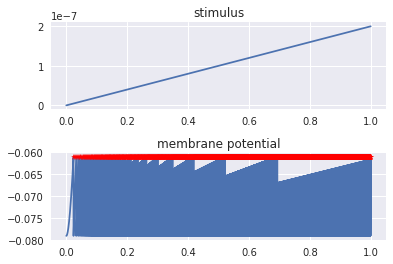

In [99]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(time, stimulus)
axes[0].set_title('stimulus')
axes[1].plot(time, v_m)
axes[1].set_title('membrane potential')
axes[1].plot(spks, np.ones(len(spks))*v_t, 'r*')
plt.subplots_adjust(hspace=0.5)

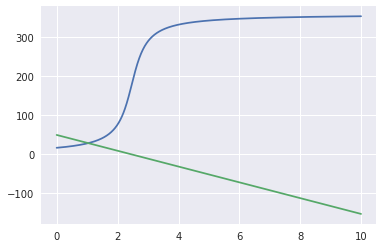

In [101]:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 15
length = 10
dt = 0.01
m = 1.5
b = 0
speeds = 1/(LV_vals/stim_size)
speed = speeds[3]
t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, length, dt, m, b)
plt.plot(t, stims)
plt.plot(t, dists)

In [454]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061

dt = 0.001
total_time = 5

noise_std = 5*1e-3
n_timepoints = int(total_time/dt)

# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[2]

m = 5.5
b = 0

t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, total_time, dt, m, b)

stimulus = tstims*1e-11
sigma = noise_std * np.sqrt(dt)
#print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)
first_spike = spks[0]
first_spike_idx = spk_idc[0]

Response angle at first spike: 33.3759753918 degree
Distance at first spike: 16.6785714286 mm


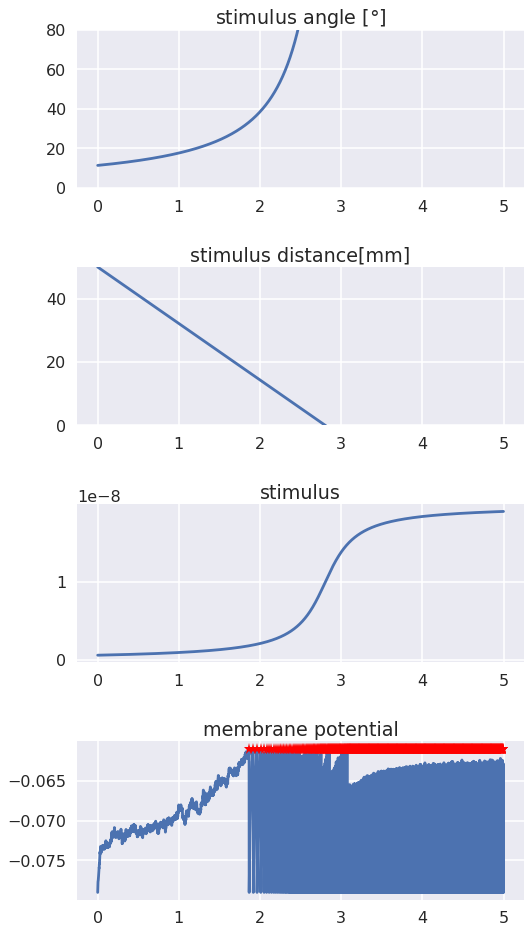

In [455]:
fig, axes = plt.subplots(4, 1, figsize=(8,16))
axes[0].plot(time, stims)
axes[0].set_title(r'stimulus angle [$ \degree $]')
axes[0].set_ylim([0, 80])
axes[1].plot(time, dists)
axes[1].set_title('stimulus distance[mm]')
axes[1].set_ylim([0, 50])
axes[2].plot(time, stimulus)
axes[2].set_title('stimulus')
axes[3].plot(time, v_m)
axes[3].set_title('membrane potential')
if not len(spks) == 0:
    axes[3].plot(spks, np.ones(len(spks))*v_t, 'r*')
plt.subplots_adjust(hspace=0.5)
print('Response angle at first spike: ' + str(stims[first_spike_idx]) + ' degree')
print('Distance at first spike: ' + str(dists[first_spike_idx]) + ' mm')

In [456]:
def calc_response(params):
    lv = np.random.rand()*1.1 + 0.1
    stim_size = np.random.rand()*15 + 10
    speed = 1/(lv/stim_size)
    t, stims, tstims, dists, t_to_coll, tstim_to_coll = transform_stim(stim_size, speed, params['total_time'],
                                                                       params['dt'], params['m'], params['b'])

    stimulus = tstims*1e-11
    sigma = params['noise_std'] * np.sqrt(params['dt'])
    noise_vals = np.random.normal(loc=0.0, scale=sigma, size=len(stimulus))

    #np.random.seed(1)
    time, v_m, spks, spk_idc = jit_lif_dynamics(params['tau_m'], params['e_l'], params['r_m'], stimulus, noise_vals,
                                                params['v_t'], params['dt'], params['total_time'])
    if not len(spks)==0:
        first_spike = spks[0]
        first_spike_idx = spk_idc[0]
    else:
        first_spike = 0
        first_spike_idx = 0
    if not first_spike_idx > len(t_to_coll):
        resp_in_t_to_coll = t_to_coll[first_spike_idx]
    else:
        resp_in_t_to_coll = 0
    return stims[first_spike_idx], dists[first_spike_idx], first_spike, lv, stim_size, speed, resp_in_t_to_coll

## One parameter set example

Mean visual angle: 52.5356683655
Mean distance: 17.6153544241
Mean reaction time: 1.324191
resp in ttc: -0.838


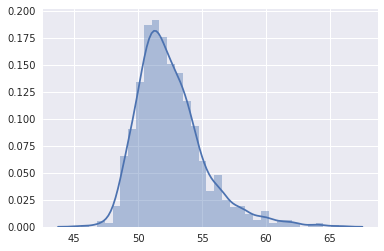

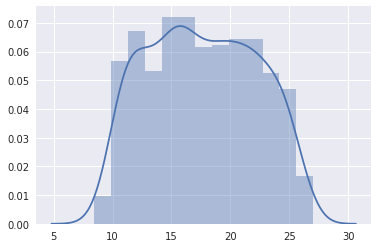

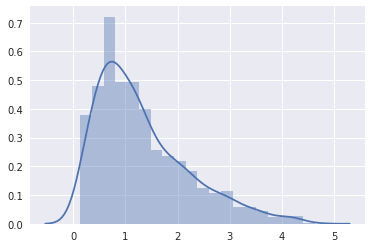

In [458]:
# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[1]

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'dt': 0.001,
          'total_time': 5,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 3.5,
          'b': 1}

nruns = 1000
rstims = np.zeros(nruns)
rdists = np.zeros(nruns)
reaction_times = np.zeros(nruns)
for i in np.arange(nruns):
    rstims[i], rdists[i], reaction_times[i], lv, stim_size, speed, resp_in_t_to_coll = calc_response(params)

import seaborn as sns
sns.set()
sns.distplot(rstims)
print('Mean visual angle: ' + str(np.mean(rstims)))
plt.figure()
sns.distplot(rdists)
print('Mean distance: ' + str(np.mean(rdists)))
plt.figure()
sns.distplot(reaction_times)
print('Mean reaction time: ' + str(np.mean(reaction_times)))
print('resp in ttc: ' + str(resp_in_t_to_coll))

# Response angle distribution as described in Bhattacharyya et al. 2017:

Text(0.5,1,'mean and std')

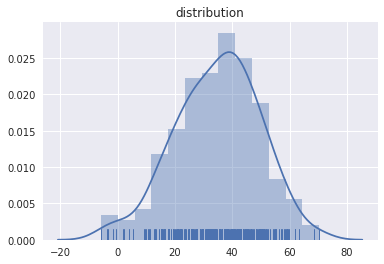

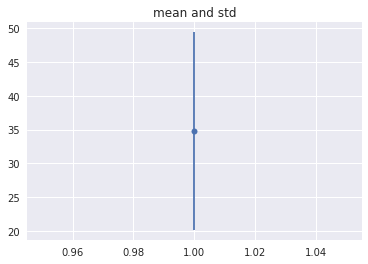

In [416]:
a = np.random.normal(loc=35, scale=15, size=246)
sns.distplot(a, rug=True)
plt.title('distribution')
plt.figure()
plt.errorbar(1, np.mean(a), yerr=np.std(a), fmt='.', ms=12)
plt.title('mean and std')

## Analyzing the influence of m, b and noise

In [444]:
import pandas as pd

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'dt': 0.001,
          'total_time': 5,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 4.5,
          'b': 5}

mvals = np.array([1, 2, 4, 6])
nmvals = len(mvals)
noisevals = np.array([1, 10, 20])*1e-3
nruns = 1000
data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'm', 'noise']
data_dict = dict([(col_name, []) for col_name in data_cols])

for noise_idx, noise in enumerate(noisevals):
    params['noise_std'] = noise
    for m_idx, mval in enumerate(mvals):
        params['m'] = mval
        for i in np.arange(nruns):
            resp_angle, resp_dist, resp_time, lv, stim_size, speed = calc_response(params)
            resp_angle = np.round(resp_angle, decimals=1)
            resp_dist = np.round(resp_dist, decimals=1)
            resp_time = np.round(resp_time, decimals=3)
            lv = np.round(lv, decimals=2)
            stim_size = np.round(stim_size, decimals=1)
            speed = np.round(speed, decimals=1)
            result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, mval, noise]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)

In [445]:
df = pd.DataFrame(data_dict)

In [446]:
df.describe()

,lv,m,noise,resp_angle,resp_dist,resp_time,speed,stim_size
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.646927,3.250000,0.010333,82.742700,17.454242,1.289113,40.328050,17.621825
std,0.319066,1.920366,0.007761,59.155614,14.739331,1.008445,34.785574,4.335774
min,0.100000,1.000000,0.001000,11.500000,-6.900000,0.000000,8.400000,10.000000
25%,0.370000,1.750000,0.001000,31.300000,4.900000,0.481000,18.800000,13.900000
50%,0.650000,3.000000,0.010000,51.300000,14.500000,1.041000,27.300000,17.700000
75%,0.920000,4.500000,0.020000,111.700000,28.700000,1.881000,47.900000,21.400000
max,1.200000,6.000000,0.020000,246.700000,50.000000,4.999000,244.500000,25.000000


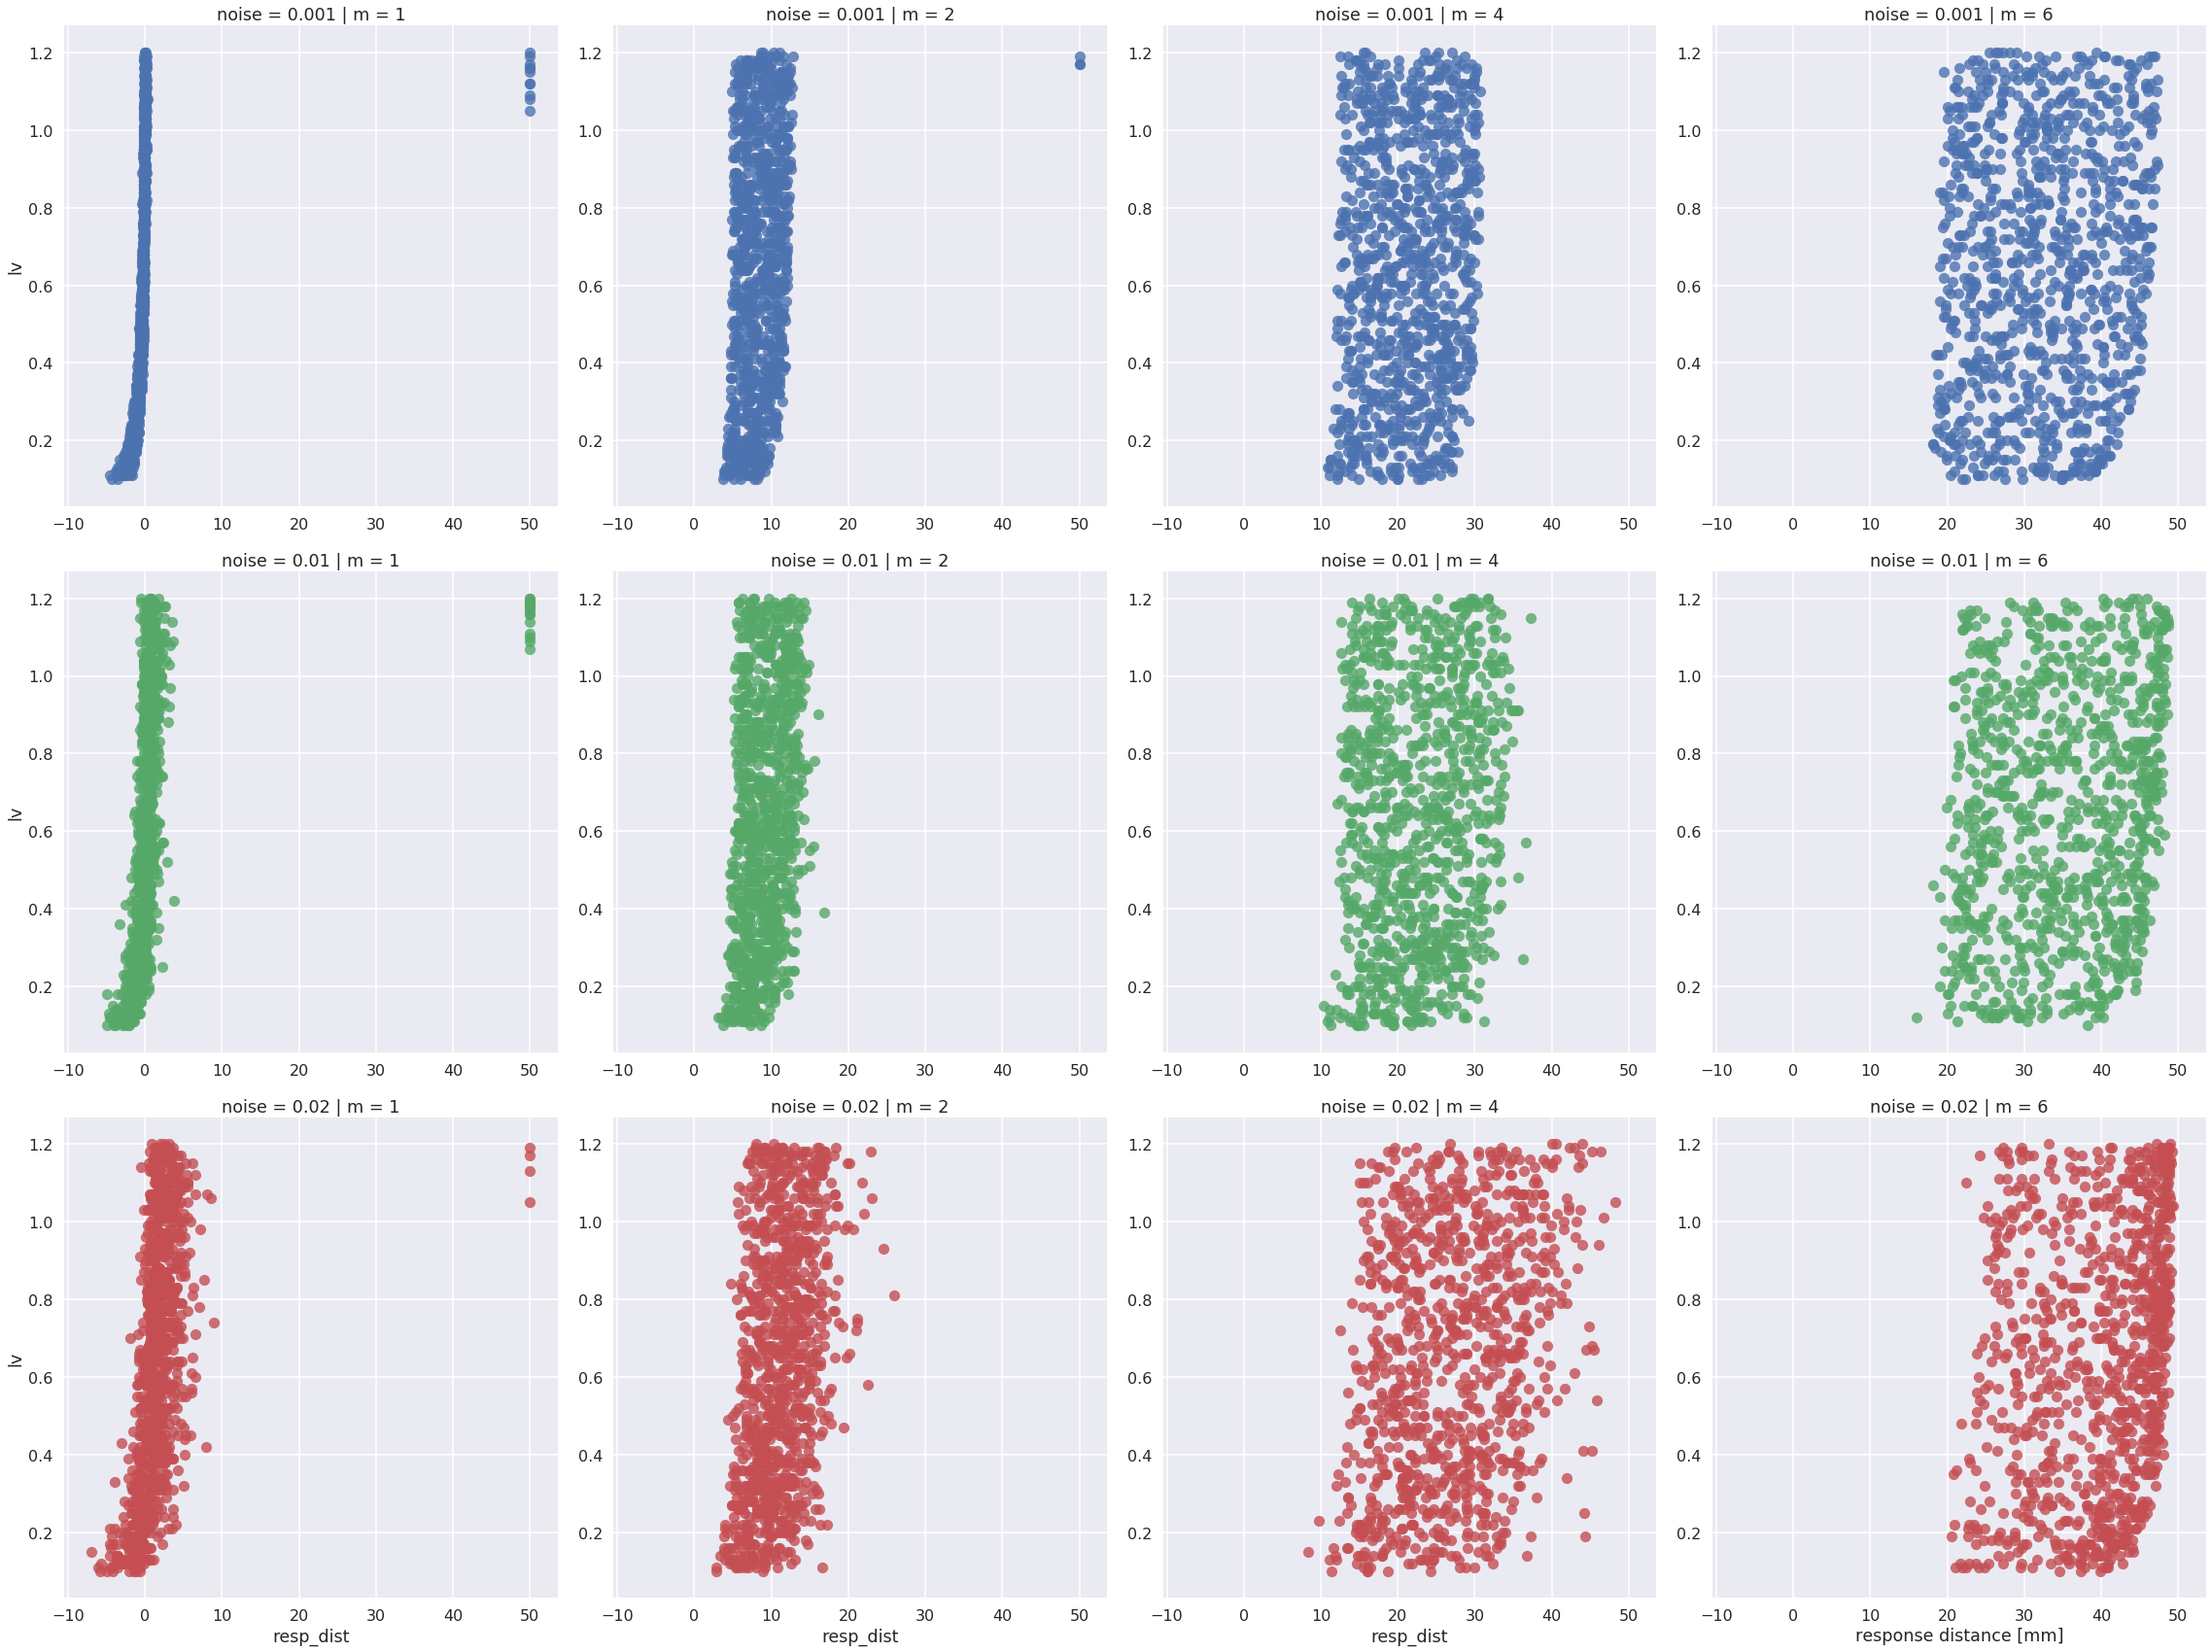

In [447]:
sns.set('poster')
g = sns.lmplot(x='resp_dist', y='lv', col='m', row='noise', hue='noise', data=df, fit_reg=False, size=8)
plt.xlabel('response distance [mm]')
g.savefig('resp_dist_vs_speed_b=5.pdf')

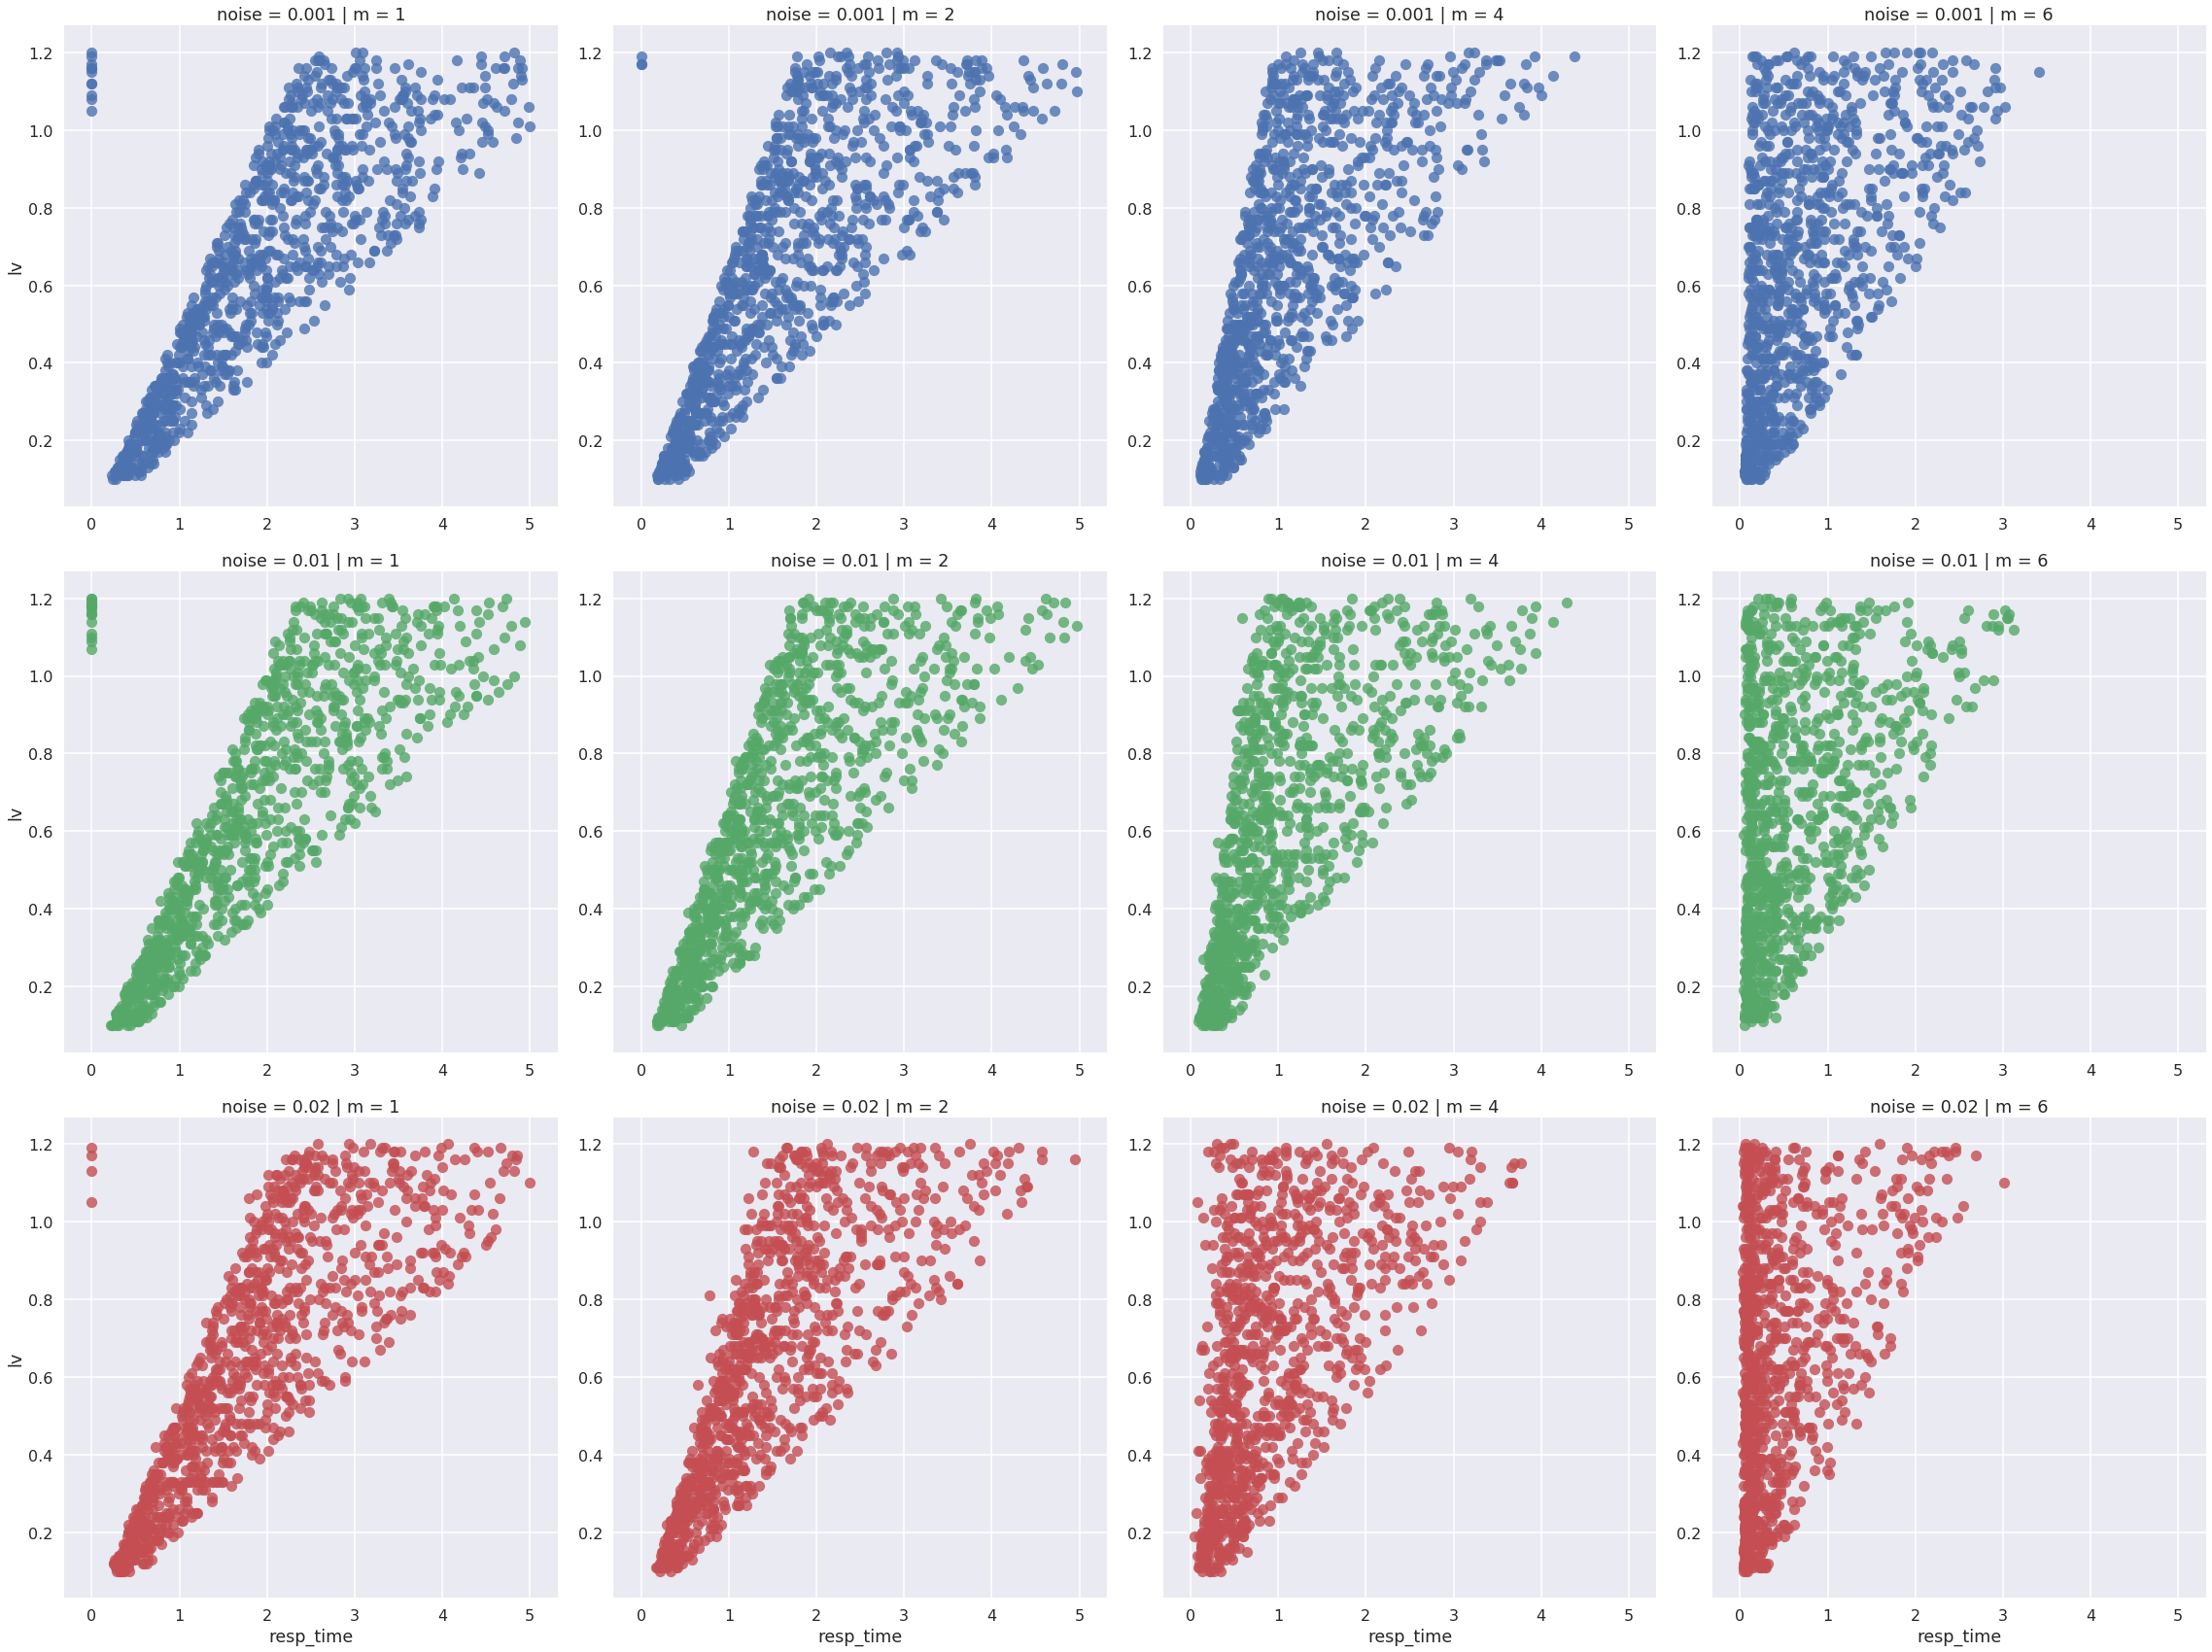

In [448]:
sns.set('poster')
g = sns.lmplot(x='resp_time', y='lv', col='m', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g.savefig('resp_time_vs_speed_b=5.pdf')

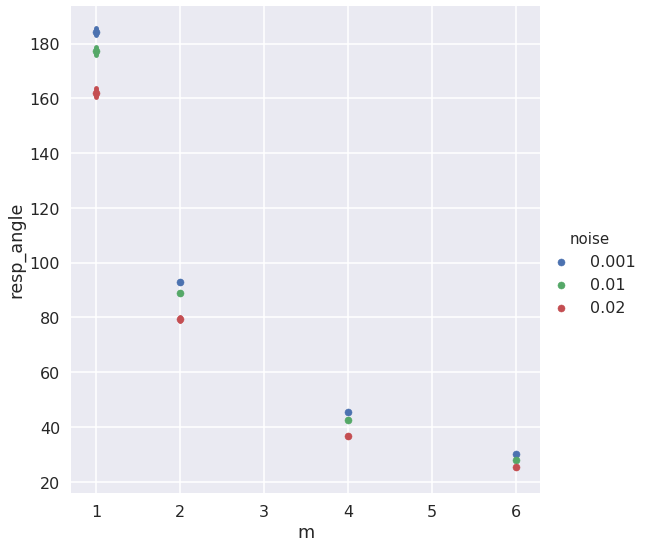

In [449]:
g = sns.lmplot(x='m', y='resp_angle', hue='noise', data=df, fit_reg=False, size=8, x_estimator=np.mean)
g.savefig('resp_angle_vs_speed_b=5.pdf')
#plt.ylim([0,80])

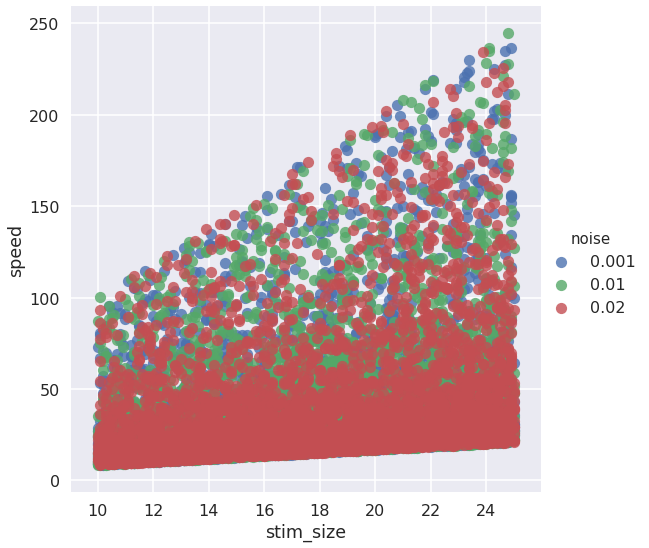

In [453]:
g = sns.lmplot(x='stim_size', y='speed', hue='noise', data=df, fit_reg=False, size=8)
#g.savefig('resp_time_vs_m_b=5.pdf')
#plt.ylim([0,80])

In [465]:
10/0.74

13.513513513513514

In [ ]:
plt.figure(figsize=(10,10))
for speed_idx, speed in enumerate(speeds):
    mrstims = np.mean(rstims[:, :, speed_idx], axis=0)
    vrstims = np.std(rstims[:, :, speed_idx], axis=0)
    sns.set('talk')
    plt.plot(mvals+speed_idx*0.1, rstims[0:100:, :, speed_idx].T, '.', color=sm.to_rgba(speed_idx), alpha=0.1)
    errline, errcaps, errbars = plt.errorbar(mvals+speed_idx*0.1, mrstims,
                                             yerr=vrstims, fmt='.',
                                             color=sm.to_rgba(speed_idx))
    plt.xlabel('slope of linear function')
    plt.ylabel('response angle [degrees]')
plt.legend()

## Profiling the LIF integration function with python vs. cython

In [22]:
%load_ext Cython

In [23]:
%%cython
import numpy as np
cimport numpy as np
DTYPE = np.double
FTYPE = np.float
ITYPE = np.int
ctypedef np.double_t DTYPE_t
ctypedef np.float_t FTYPE_t
ctypedef np.int_t ITYPE_t

def c_lif_dynamics(float tau_m, float e_l, float r_m, np.ndarray[DTYPE_t] stimulus, np.ndarray[DTYPE_t] noise,
                   float v_t, float dt, int n_timepoints, np.ndarray[DTYPE_t] v_m, np.ndarray[DTYPE_t] spks):

    v_m[0] = e_l
    # integration:
    cdef int t = 1
    while t < n_timepoints:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            spks[t] = 1
        t = t + 1

    return v_m, spks

In [24]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061

dt = 0.0001
total_time = 1

noise_std = 10*1e-15
n_timepoints = int(total_time/dt)

stimulus = np.arange(n_timepoints)*20.0*1e-12
sigma = np.sqrt(2.0 * noise_std * dt)
print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)

1.41421356237e-09


In [25]:
%timeit lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)

8.46 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
@jit
def jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = e_l
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [27]:
%timeit jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time)

157 µs ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061

dt = 0.0001
total_time = int(1)

noise_std = 10*1e-15
n_timepoints = int(total_time/dt)

stimulus = np.arange(n_timepoints)*20.0*1e-12
stimulus = stimulus.astype('double')
sigma = np.sqrt(2.0 * noise_std * dt)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
noise_vals = noise_vals.astype('double')
#stimulus = noise_vals + stimulus

v_m = np.zeros(n_timepoints, dtype='double')
spks = np.array(np.zeros(n_timepoints), dtype='double')
#time = np.arange(p_T)*self.dt

#spks = (np.where(spks==1)[0])*self.dt

%timeit c_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, n_timepoints, v_m, spks)

62.7 µs ± 487 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Next steps:
[ ] => open task

[x] => completed task

- [x] implement two different stimuli as visual angles (theta) over time
    - [x] values for L/V from Bhattacharyya2017: 
constant values of L/V (bin 1: center L/V = 0.19 s,
Ntrials = 29, bin 2: center L/V = 0.38 s, Ntrials = 34,
bin 3: center L/V = 0.56 s, Ntrials = 45, bin 4: center
L/V = 0.74 s, Ntrials = 49, bin 5: center L/V = 0.93 s,
Ntrials = 44, bin 6: center L/V = 1.11 s, Ntrials = 44),

- [x] implement parametrized linear function that gets the theta time series and returns the linear transform of it according to given parameters
- [ ] use LIF with parameter values from Koyama2016 and tune parameters of linear function to achieve firing latencies/reactive distance from Bhattacharyya
    - [x] take noise calculation out of the lif function and just add it to the stimulus so that the units are clear
    - [ ] take the generated stimuli and plot "response angle" and reaction distance against slope and offset of the linear transformation function